# Tarea 3

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline 
dpi = 200

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


def log_like(w, x, y): # - log likelihood
    # aumentar dimension para modelo lineal
    sig = sigmoid(x@w)
    return - np.sum(y*np.log(sig) + (1 - y)*np.log(1 - sig))


def prediccion(y_pred, y):
    """Retorna el total de la muestra, hits y % de precision"""
    total = len(y)
    hits = np.sum(y_pred==y)
    return total, hits, np.around(hits/total, 2)*100


def log_normal(mu, sigma, x):
    dim = len(mu)
    cen = x - mu
    return - 0.5*cen@np.linalg.inv(sigma)@cen.T - np.log((2*np.pi)**dim*np.linalg.det(sigma))
    
    
def met_has(w0, N, X, Y, prior=None, s1=1e-2):  # prior=None->Uniforme
                                                # prior=5->Gaussiana de cov diagonal 5 y mu=w0
    ndim = len(w0)
    p0 = - log_like(w0, X, Y) # "-" para obtener la log likelihood de vuelta
    if prior!=None:
        cov_prior = np.eye(ndim)*prior
        p0 += log_normal(mu=w0, sigma=cov_prior, x=w0)
    chain = []
    i = 0
    j = 0
    while i<N:
        w1 = np.random.multivariate_normal(w0, np.eye(ndim)*s1)
        p1 = - log_like(w1, X, Y)
        if prior!=None:
            p1 += log_normal(mu=w0, sigma=cov_prior, x=w1)
        un = np.log(np.random.uniform(0, 1))
        alpha = min(0, p1 - p0)
        if alpha>=un:
            chain.append(w1)
            p0 = p1
            w0 = w1
            i += 1
        j += 1
    print('acept', i/j)
    return np.array(chain)


def plt_bar(data, xlabel, title, lmin, lmax, ml, bins=10):
    # data: n samples, d dimensions
    dim = data.shape[1]
    moda = []
    for i in range(dim): # recorre parametros
        fig = plt.subplot(3, 1, i + 1)
        if i==0:
            fig.set_title(title)
        counts, limits = np.histogram(data.T[i], bins=bins, density=True, range=(lmin[i], lmax[i]))
        width = limits[1] - limits[0]
        limits = (limits[1:] + limits[:-1])/2
        print('moda '+xlabel[i], np.around(limits[np.argmax(counts)], 2))
        fig.bar(limits, counts, width=width*0.9, tick_label=np.around(limits, 1), color='navy')
        fig.axvline(ml[i], color='red')
        fig.set_ylabel('nor. counts ' + xlabel[i])
        moda.append(limits[np.argmax(counts)])
    return moda

In [9]:
datos = np.genfromtxt('datosT3_.txt', dtype='float', delimiter=',')

Muestras clase 0: 421
Muestras clase 1: 579


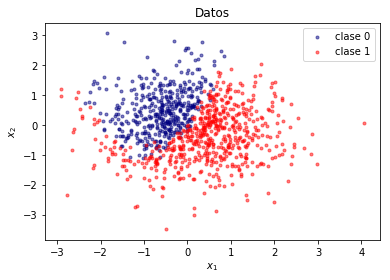

In [10]:
clase_0 = datos[2]==0
clase_1 = datos[2]==1

print('Muestras clase 0:', np.sum(datos[2]==0))
print('Muestras clase 1:', np.sum(datos[2]==1))

# plot de datos
plt.scatter(datos[0][clase_0], datos[1][clase_0], marker='.', color='navy', label='clase 0', alpha=0.5)
plt.scatter(datos[0][clase_1], datos[1][clase_1], marker='.', color='red', label='clase 1', alpha=0.5)
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.legend()
plt.title('Datos')
plt.savefig('datos', dpi=dpi)

## Regresión logística

### Modelo: $f(\textbf{x}) = w_{1}x_{1} + w_{2}x_{2} + w_{0}$
### Verosimilitud: $- \log(L) = - \sum_{i} \left [ y_{i}\log(\sigma(f(\textbf{x}))) + (1 - y_{i})\log(1 - \sigma(f(\textbf{x}))) \right ]$

In [11]:
# solucion de la regresion logistica
X = datos[:2].T
Y = datos[2]
x0 = np.random.uniform(0, 1, 3)
if len(x0)==3:
    X = np.vstack((X.T, np.ones(len(X)))).T
w_opt = minimize(fun=log_like, x0=x0, args=(X, Y), method='L-BFGS-B').x
print('w =', w_opt)

# resultados de clasificacion
y_pred = sigmoid(X@w_opt)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1

res = prediccion(y_pred, Y)
print('hits =', res[1], '/', res[0])
print('precision =', res[2], '%')


w = [ 2.23175228 -2.19647481  0.7166496 ]
hits = 871 / 1000
precision = 87.0 %


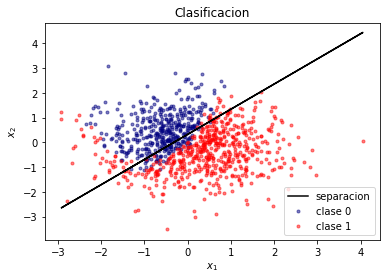

In [12]:
# plot recta separadora de clases

x = datos[0]
y_opt = (- w_opt[2] - w_opt[0]*x)/w_opt[1]

plt.plot(x, y_opt, color='black', label='separacion')
plt.scatter(datos[0][clase_0], datos[1][clase_0], marker='.', color='navy', label='clase 0', alpha=0.5)
plt.scatter(datos[0][clase_1], datos[1][clase_1], marker='.', color='red', label='clase 1', alpha=0.5)
plt.legend()
plt.title('Clasificacion')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.savefig('clasificacion', dpi=dpi)

## Metropolis Hastings

### Prior uniforme

acept 0.2522704339051463


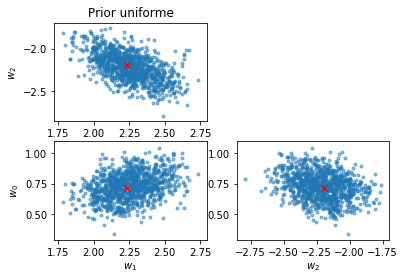

In [13]:
muestras_u = met_has(w_opt, 1000, X, Y, prior=None, s1=3.8*1e-2)

fig1 = plt.subplot(2, 2, 1)
fig2 = plt.subplot(2, 2, 3)
fig3 = plt.subplot(2, 2, 4)
fig1.scatter(muestras_u.T[0], muestras_u.T[1], marker='.', alpha=0.5)
fig2.scatter(muestras_u.T[0], muestras_u.T[2], marker='.', alpha=0.5)
fig3.scatter(muestras_u.T[1], muestras_u.T[2], marker='.', alpha=0.5)
fig1.scatter(w_opt[0], w_opt[1], marker='x', color='red')
fig2.scatter(w_opt[0], w_opt[2], marker='x', color='red')
fig3.scatter(w_opt[1], w_opt[2], marker='x', color='red')

fig1.set_ylabel(r'$w_{2}$')
fig2.set_xlabel(r'$w_{1}$')
fig2.set_ylabel(r'$w_{0}$')
fig3.set_xlabel(r'$w_{2}$')
fig1.set_title('Prior uniforme')
plt.savefig('mcmc_u', dpi=dpi)

### Prior gaussiano
$\Sigma = I\sigma^{2} = I$

acept 0.24189646831156264


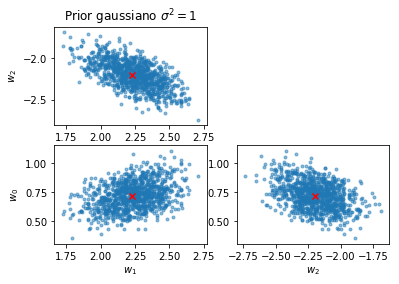

In [14]:
muestras_n1 = met_has(w_opt, 1000, X, Y, prior=1, s1=3.8*1e-2)

fig1 = plt.subplot(2, 2, 1)
fig2 = plt.subplot(2, 2, 3)
fig3 = plt.subplot(2, 2, 4)
fig1.scatter(muestras_n1.T[0], muestras_n1.T[1], marker='.', alpha=0.5)
fig2.scatter(muestras_n1.T[0], muestras_n1.T[2], marker='.', alpha=0.5)
fig3.scatter(muestras_n1.T[1], muestras_n1.T[2], marker='.', alpha=0.5)
fig1.scatter(w_opt[0], w_opt[1], marker='x', color='red')
fig2.scatter(w_opt[0], w_opt[2], marker='x', color='red')
fig3.scatter(w_opt[1], w_opt[2], marker='x', color='red')

fig1.set_ylabel(r'$w_{2}$')
fig2.set_xlabel(r'$w_{1}$')
fig2.set_ylabel(r'$w_{0}$')
fig3.set_xlabel(r'$w_{2}$')
fig1.set_title('Prior gaussiano $\sigma^{2}=1$')
plt.savefig('mcmc_n1', dpi=dpi)

### Prior Gaussiano
$\Sigma = I\sigma^{2} = 10\cdot I$

acept 0.2515090543259557


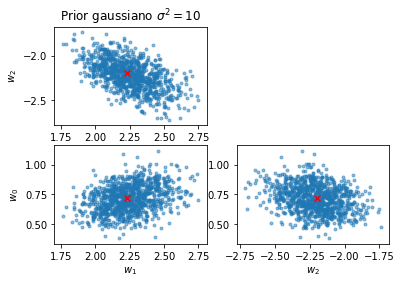

In [15]:
muestras_n2 = met_has(w_opt, 1000, X, Y, prior=10, s1=3.8*1e-2)

fig1 = plt.subplot(2, 2, 1)
fig2 = plt.subplot(2, 2, 3)
fig3 = plt.subplot(2, 2, 4)
fig1.scatter(muestras_n2.T[0], muestras_n2.T[1], marker='.', alpha=0.5)
fig2.scatter(muestras_n2.T[0], muestras_n2.T[2], marker='.', alpha=0.5)
fig3.scatter(muestras_n2.T[1], muestras_n2.T[2], marker='.', alpha=0.5)
fig1.scatter(w_opt[0], w_opt[1], marker='x', color='red')
fig2.scatter(w_opt[0], w_opt[2], marker='x', color='red')
fig3.scatter(w_opt[1], w_opt[2], marker='x', color='red')

fig1.set_ylabel(r'$w_{2}$')
fig2.set_xlabel(r'$w_{1}$')
fig2.set_ylabel(r'$w_{0}$')
fig3.set_xlabel(r'$w_{2}$')
fig1.set_title('Prior gaussiano $\sigma^{2}=10$')
plt.savefig('mcmc_n2', dpi=dpi)

### Histogramas

In [16]:
mins = []
maxs = []
for i in range(3):
    w_min = min(min(muestras_u.T[i]), min(muestras_n1.T[i]), min(muestras_n2.T[i]))
    w_max = max(max(muestras_u.T[i]), max(muestras_n1.T[i]), max(muestras_n2.T[i]))
    mins.append(w_min)
    maxs.append(w_max)

moda $w_{1}$ 2.26
moda $w_{2}$ -2.27
moda $w_{0}$ 0.71


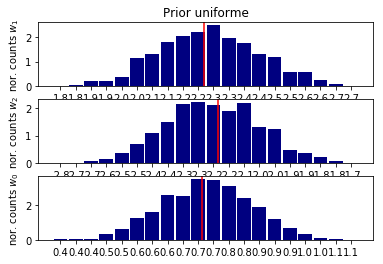

In [17]:
moda_u = plt_bar(muestras_u, [r'$w_{1}$', r'$w_{2}$', r'$w_{0}$'], 'Prior uniforme', mins, maxs, w_opt, 20)
plt.savefig('hist_u', dpi=dpi)

moda $w_{1}$ 2.26
moda $w_{2}$ -2.21
moda $w_{0}$ 0.75


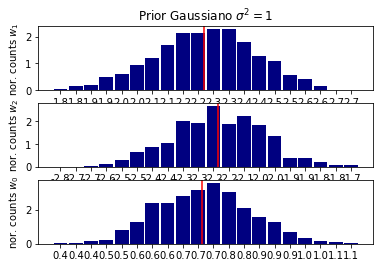

In [18]:
moda_n1 = plt_bar(muestras_n1, [r'$w_{1}$', r'$w_{2}$', r'$w_{0}$'], r'Prior Gaussiano $\sigma^{2}=1$', mins, maxs, w_opt, 20)
plt.savefig('hist_n1', dpi=dpi)

moda $w_{1}$ 2.21
moda $w_{2}$ -2.21
moda $w_{0}$ 0.67


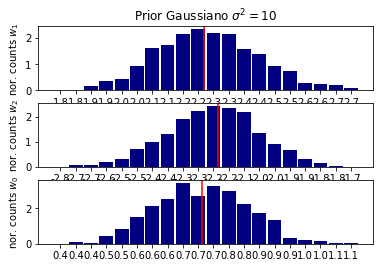

In [19]:
moda_n2 = plt_bar(muestras_n2, [r'$w_{1}$', r'$w_{2}$', r'$w_{0}$'],r'Prior Gaussiano $\sigma^{2}=10$', mins, maxs, w_opt, 20)
plt.savefig('hist_n2', dpi=dpi)

### Rectas 

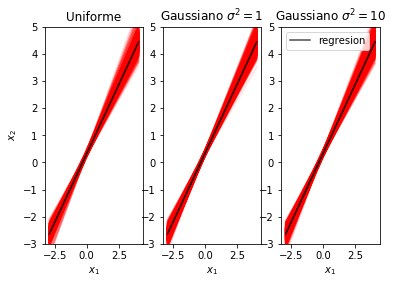

In [20]:
mu_copy = np.copy(muestras_u)
np.random.shuffle(mu_copy) # se seleccionan las rectas de manera aleatoria

mn1_copy = np.copy(muestras_n1)
np.random.shuffle(mn1_copy)

mn2_copy = np.copy(muestras_n2)
np.random.shuffle(mn2_copy)

fig1 = plt.subplot(1, 3, 1)
fig2 = plt.subplot(1, 3, 2)
fig3 = plt.subplot(1, 3, 3)

for i in range(1000): # se grafican 1000 rectas
    y1 = (- mu_copy[i, 2] - mu_copy[i, 0]*x)/mu_copy[i, 1]
    y2 = (- mn1_copy[i, 2] - mn1_copy[i, 0]*x)/mn1_copy[i, 1]
    y3 = (- mn2_copy[i, 2] - mn2_copy[i, 0]*x)/mn2_copy[i, 1]
    fig1.plot(x, y1, color='red', alpha=0.1)
    fig2.plot(x, y2, color='red', alpha=0.1)
    fig3.plot(x, y3, color='red', alpha=0.1)
    
fig1.plot(x, y_opt, color='black', alpha=0.7, label='regresion')
fig2.plot(x, y_opt, color='black', alpha=0.7, label='regresion')
fig3.plot(x, y_opt, color='black', alpha=0.7, label='regresion')

fig1.set_xlabel(r'$x_{1}$')
fig2.set_xlabel(r'$x_{1}$')
fig3.set_xlabel(r'$x_{1}$')
fig1.set_ylabel(r'$x_{2}$')
fig1.set_ylim([-3, 5])
fig2.set_ylim([-3, 5])
fig3.set_ylim([-3, 5])
fig1.set_title('Uniforme')
fig2.set_title('Gaussiano $\sigma^{2}=1$')
fig3.set_title('Gaussiano $\sigma^{2}=10$')

plt.legend()
plt.savefig('rectas', dpi=dpi)